<a href="https://colab.research.google.com/github/sahana3131/potatotaskdl/blob/main/potatodiseasedl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for i_batch, l_batch in dataset.take(1):
    print(i_batch.shape)
    print(l_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 2 1 1 1 2 1 0 0 1 0 1 0 0 0 1 0 2 1 2 1 1 0 0 1 1 2 1]


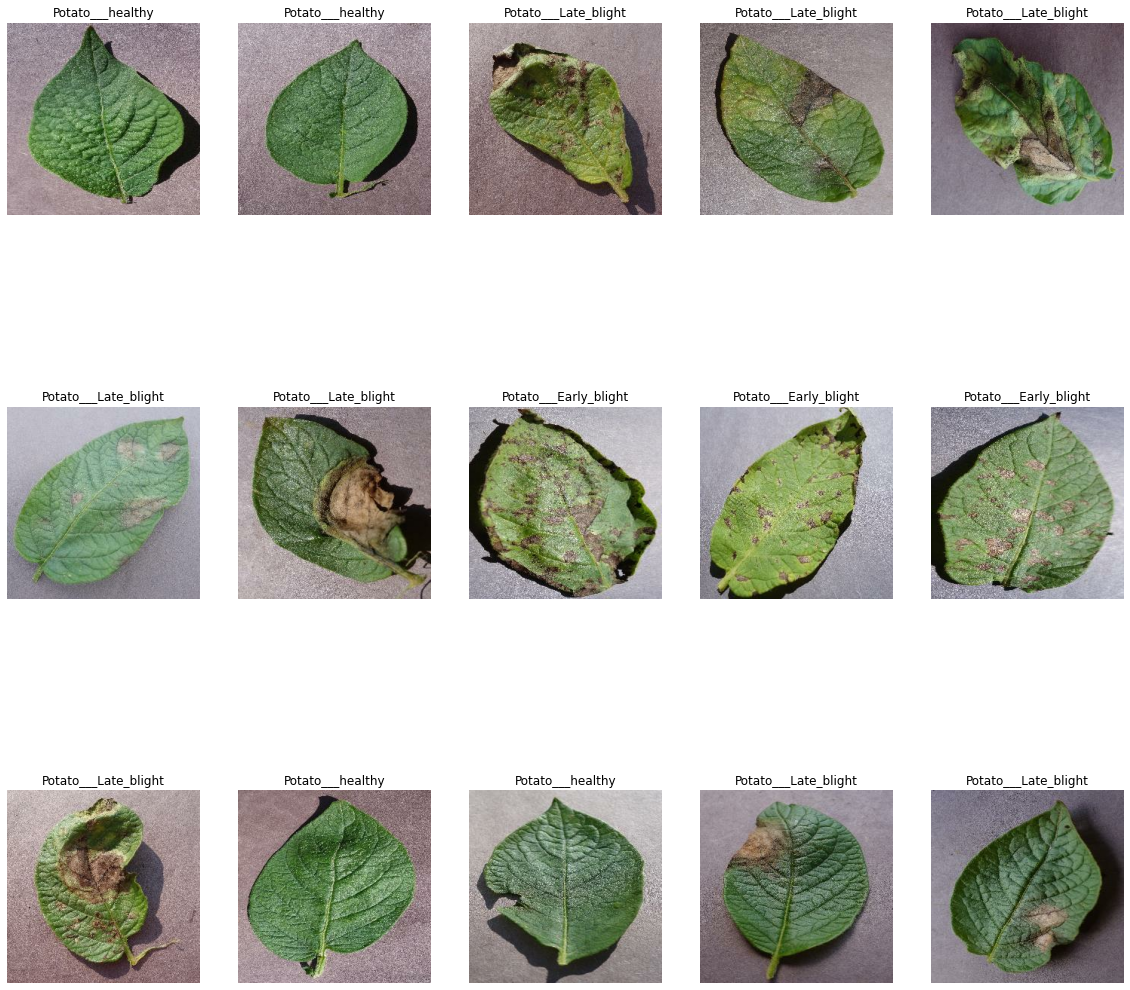

In [ ]:
plt.figure(figsize=(20,20))
for i_batch, l_batch in dataset.take(1):
    for i in range(15):
        ax=plt.subplot(3,5,i+1)
        plt.imshow(i_batch[i].numpy().astype("uint8"))
        plt.title(class_name[l_batch[i]])
        plt.axis("off")

In [ ]:
training_size=0.8
len(dataset)*training_size

54.400000000000006

In [ ]:
train_dataset=dataset.take(54)
len(train_dataset)

54

In [ ]:
temp_dataset=dataset.skip(54)

In [ ]:
len(temp_dataset)

14

In [ ]:
validation_size=0.5
print(int(len(temp_dataset)*validation_size))

7


In [ ]:
validation_dataset=temp_dataset.take(7)
len(validation_dataset)

7

In [ ]:
test_dataset=temp_dataset.skip(7)

In [ ]:
def partitions(dset,training_split=0.8,temp_split=0.2,validation_split=0.5,test_split=0.5,shuffle=True,shuffle_size=10000):
    dset_size=len(dset)
    if shuffle:
        dset=dset.shuffle(shuffle_size,seed=12)
        
    training_size=int(training_split*dset_size)
    temp_size=int(temp_split*dset_size)
    validation_size=int(validation_split*temp_size)
    
    training_dset=dset.take(training_size)
    tempset=dset.skip(training_size)
    validation_dset=tempset.take(validation_size)
    
    test_dset=tempset.skip(validation_size)
    return training_dset,tempset,validation_dset,test_dset

In [ ]:
training_dset,tempset,validation_dset,test_dset=partitions(dataset)

In [ ]:
print(len(training_dset))
print(len(validation_dset))
print(len(test_dset))

54
6
8


In [ ]:
training_dset=training_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dset=validation_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dset=test_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential(
[
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential(
[
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),    
])
model.build(input_shape=input_shape)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [ ]:
history=model.fit(
training_dset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dset
)

Epoch 1/50


C:\Users\SAHANA\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 140s 2s/step - loss: 0.8973 - accuracy: 0.4716 - val_loss: 0.7930 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 111s 2s/step - loss: 0.6694 - accuracy: 0.6863 - val_loss: 0.5660 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 104s 2s/step - loss: 0.5000 - accuracy: 0.7888 - val_loss: 0.3878 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 101s 2s/step - loss: 0.4045 - accuracy: 0.8322 - val_loss: 0.3562 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 100s 2s/step - loss: 0.6230 - accuracy: 0.7512 - val_loss: 0.5467 - val_accuracy: 0.7396
Epoch 6/50
54/54 [==============================] - 102s 2s/step - loss: 0.4713 - accuracy: 0.7975 - val_loss: 0.4973 - val_accuracy: 0.8229
Epoch 7/50
54/54 [==============================] - 101s 2s/step - loss: 0.3675 - accuracy: 0.8513 - val_loss: 0.4114 - val_accuracy: 0.8229
Epoch 8/50
54/54 [======

In [ ]:
scores=model.evaluate(test_dset)

8/8 [==============================] - 6s 358ms/step - loss: 0.0697 - accuracy: 0.9727


In [ ]:
scores

[0.06971196830272675, 0.97265625]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.47164350748062134,
 0.6863425970077515,
 0.7887731194496155,
 0.8321759104728699,
 0.7511574029922485,
 0.7974537014961243,
 0.8512731194496155,
 0.8825231194496155,
 0.9027777910232544,
 0.8987268805503845,
 0.9010416865348816,
 0.9201388955116272,
 0.9409722089767456,
 0.9172453880310059,
 0.9456018805503845,
 0.9363425970077515,
 0.9542824029922485,
 0.9467592835426331,
 0.9722222089767456,
 0.9456018805503845,
 0.9641203880310059,
 0.9751157164573669,
 0.9646990895271301,
 0.9716435074806213,
 0.9751157164573669,
 0.9739583134651184,
 0.9594907164573669,
 0.9681712985038757,
 0.9832175970077515,
 0.9791666865348816,
 0.9728009104728699,
 0.9774305820465088,
 0.9837962985038757,
 0.9878472089767456,
 0.9878472089767456,
 0.9728009104728699,
 0.984375,
 0.984375,
 0.9809027910232544,
 0.9756944179534912,
 0.9751157164573669,
 0.9820601940155029,
 0.9826388955116272,
 0.9866898059844971,
 0.9791666865348816,
 0.9895833134651184,
 0.9947916865348816,
 0.984375,
 0.9936342835426331,


Text(0.5, 1.0, 'Training and Validation Accuracy')

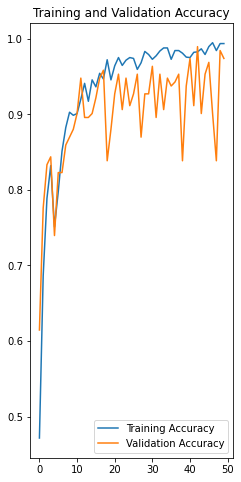

In [ ]:
epochs_range=range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

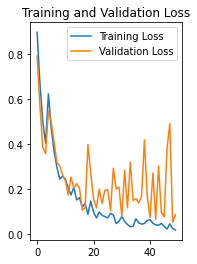

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
np.argmax([[1.8834946e-10,5.0802645e-04,9.9949193e-01]])

2

In [ ]:
import numpy as np
for images_batch,labels_batch in test_dset.take(1):
    print(i_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[150., 140., 151.],
        [119., 109., 120.],
        [132., 122., 133.],
        ...,
        [195., 182., 192.],
        [155., 142., 152.],
        [132., 119., 129.]],

       [[167., 157., 168.],
        [180., 170., 181.],
        [133., 123., 134.],
        ...,
        [192., 179., 189.],
        [227., 214., 224.],
        [164., 151., 161.]],

       [[141., 131., 142.],
        [142., 132., 143.],
        [168., 158., 169.],
        ...,
        [162., 149., 159.],
        [186., 173., 183.],
        [136., 123., 133.]],

       ...,

       [[163., 144., 150.],
        [175., 156., 162.],
        [171., 152., 158.],
        ...,
        [180., 160., 161.],
        [122., 102., 103.],
        [123., 103., 104.]],

       [[164., 145., 151.],
        [171., 152., 158.],
        [165., 146., 152.],
        ...,
        [173., 153., 154.],
        [156., 136., 137.],
       

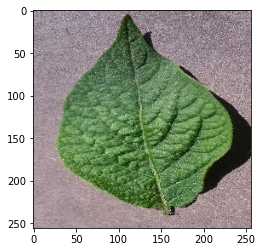

In [ ]:
for images_batch,labels_batch in test_dset.take(1):
    plt.imshow(i_batch[0].numpy().astype("uint8"))

first image to predict
first image's actual label: Potato___Late_blight


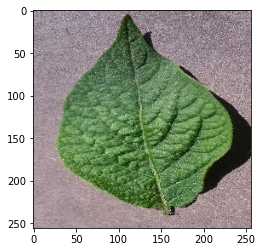

In [ ]:
for images_batch,labels_batch in test_dset.take(1):
    first_image=i_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_name[first_label])

In [ ]:
batch_prediction=model.predict(i_batch)
print(batch_prediction[0])

1/1 [==============================] - 0s 285ms/step
[1.8834946e-10 5.0802645e-04 9.9949193e-01]


In [ ]:
def predict(model,img):
    i_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

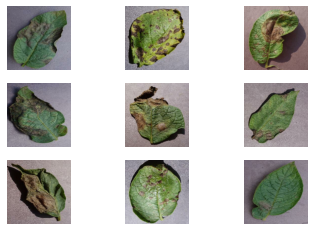

In [ ]:
for images,labels in test_dset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")